## Linear least-squares and a bland dense network

We're going to use the MIT-BIH datasets to train and test a basic feedforward network and see how it does. We'll compare the results to a linear regression.

In [1]:
import logging
import numpy as np
import tensorflow as tf

import tools.plotdata as pltdat
import tools.train as tr

## Read in data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, df = tr.preprocess(*files, fft=True)
tr.class_count(df)


Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


Let's look at a few random samples of the training data:

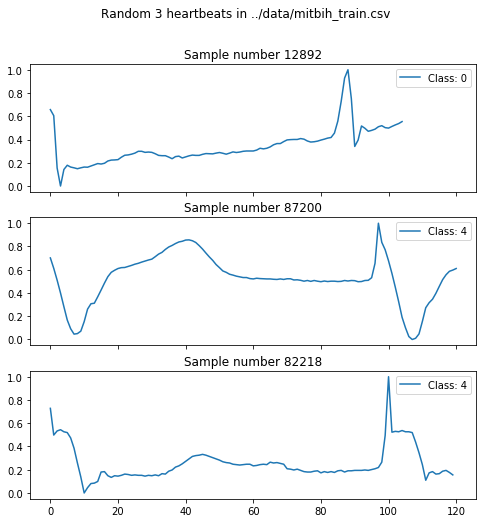

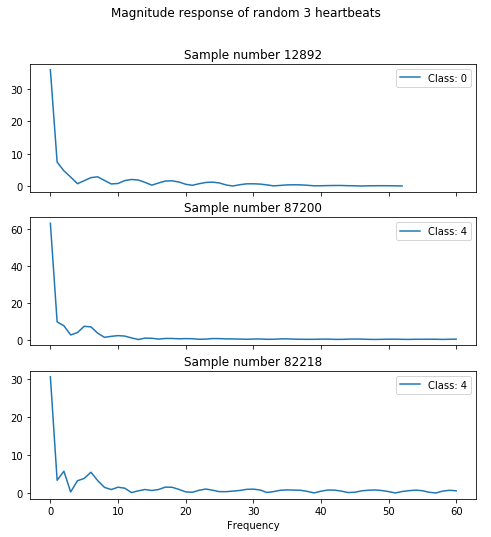

In [2]:
pltdat.plot_ecg(files[0], 3)

### Least-squares
Let's try least-squares regression with numpy.

In [3]:
lstsq_soln = np.linalg.lstsq(inputs["train"], labels["train"], rcond=None)
print("Rank of training dataset:", lstsq_soln[2])

Rank of training dataset: 94


Now let's see how accurate it is.

In [4]:
coeffs = lstsq_soln[0]
predict = {}
accuracy = {}
for key in inputs:
    predict[key] = np.argmax(np.dot(inputs[key], coeffs), axis=1)
    num_correct = np.sum(
        labels[key][range(labels[key].shape[0]), predict[key]] == 1
    )
    accuracy[key] = num_correct / labels[key].shape[0]
print("Training accuracy:", accuracy["train"])
print("Test accuracy:", accuracy["test"])

Training accuracy: 0.9001073623135436
Test accuracy: 0.8965375479627261


### Dense feed-forward network
Let's try an unregularized, bland feed-forward network with a couple of hidden layers.

In [5]:
config = {"batch_size": 200, "val_split": 0.2, "epochs": 20}
hiddenlayers = [(5, "relu"), (5, "relu")]
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
tr.train_dense(inputs, labels, hiddenlayers, config)

Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 94)]              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 475       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
Total params: 535
Trainable params: 535
Non-trainable params: 0
_________________________________________________________________

Training
Train on 70043 samples, validate on 17511 samples
Epoch 1/20
70043/70043 [==============================] - 2s 26us/sample - loss: 0.7216 - categorical_accuracy: 0.7823 - val_loss: 0.5323 - val_categorical_accuracy: 0.8371
Epoch 2/20
70043/70043